<a href="https://colab.research.google.com/github/gift-framework/GIFT/blob/research/notebooks/colab_atlas_a2c_production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atlas A2c — Production G₂ Metric Re-Training with Analytical Warm-Start

**Version**: A2c | **Target**: Colab A100 | **Budget**: ~4h | **Epochs**: 55k

## Key Innovations vs A2b

| # | Problem | A2c Fix |
|---|---------|--------|
| 1 | Bulk_R 3x offset from G0 | `base_diag = softplus_inv(diag(cholesky(G0)))` |
| 2 | Generic warm-start | Supervised loss from exact G0 (28 numbers) |
| 3 | Too many epochs (81k) | 55k epochs |
| 4 | No embedded validation | A14-A16 diagnostics |
| 5 | 3 separate .pt | Single unified .pt |


In [1]:
# === Cell 1: GPU + Imports ===
import os, sys, time, math, json, copy
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Tuple
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64

if device.type == "cuda":
    torch.backends.cuda.matmul.allow_tf32 = False
    torch.backends.cudnn.allow_tf32 = False

print(f"PyTorch {torch.__version__}")
print(f"Device: {device}")
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    props = torch.cuda.get_device_properties(0)
    print(f"Memory: {props.total_memory / 1e9:.1f} GB")

torch.manual_seed(42)
np.random.seed(42)


PyTorch 2.9.0+cu128
Device: cuda
GPU: NVIDIA A100-SXM4-80GB
Memory: 85.1 GB


/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


In [2]:
# === Cell 2: A2cConfig ===
@dataclass
class A2cConfig:
    neck_hidden: List[int] = field(default_factory=lambda: [320, 320, 256, 192])
    bulk_hidden: List[int] = field(default_factory=lambda: [320, 320, 256, 192])
    num_random_freq: int = 32
    num_periodic_freq: int = 12
    neck_perturbation_scale: float = 0.5
    bulk_perturbation_scale: float = 0.3
    use_residual: bool = True
    phase1_neck_epochs: int = 8000
    phase1_bulk_epochs: int = 6000
    batch_size: int = 2048
    phase2_schwarz_iters: int = 15
    phase2_epochs_per_step: int = 600
    phase3_joint_epochs: int = 8000
    spectral_n_basis: int = 80
    spectral_n_mc: int = 80000
    @property
    def fourier_output_dim(self):
        return 2 * self.num_random_freq + 4 * self.num_periodic_freq

cfg = A2cConfig()
print(f"A2c Config: Neck {cfg.phase1_neck_epochs}ep, Bulk {cfg.phase1_bulk_epochs}ep, "
      f"Schwarz {cfg.phase2_schwarz_iters}x{cfg.phase2_epochs_per_step}, Joint {cfg.phase3_joint_epochs}ep")


A2c Config: Neck 8000ep, Bulk 6000ep, Schwarz 15x600, Joint 8000ep


In [3]:
# === Cell 3: Constants + G0 (hardcoded from A11) ===
B2, B3, DIM_G2, H_STAR = 21, 77, 14, 99
DET_G_TARGET = 65 / 32
SCALE_FACTOR = (65 / 32) ** (1 / 14)
KAPPA_T = 1.0 / 61
TORSION_THRESHOLD = 0.0288
MU_DECAY = 0.8

# The 28 independent numbers of G0 (from A11 extraction, 200k MC)
G0_np = np.array([
    [ 1.1142524007496286,  4.034612167549135e-05, -2.5804913295081982e-05,
      4.573451415661761e-05,  5.673131412197492e-05,  1.818254318021353e-04,
      7.958596383092335e-05],
    [ 4.034612167549134e-05,  1.1296895301523837,  3.7386768557188545e-04,
     -2.550246370913405e-04,  9.987618122336805e-05,  1.1170799466815775e-04,
      1.4046480413399165e-05],
    [-2.5804913295081982e-05,  3.7386768557188545e-04,  1.0895110667192778,
      6.753224579292082e-03, -5.980813877938918e-03, -2.769065165341549e-03,
      2.344133177665551e-04],
    [ 4.5734514156617604e-05, -2.550246370913405e-04,  6.753224579292082e-03,
      1.090267779488871,  3.4842382278606e-03,  1.3465957341761007e-03,
     -1.2159555580175938e-04],
    [ 5.673131412197492e-05,  9.987618122336805e-05, -5.980813877938918e-03,
      3.4842382278606e-03,  1.0951896854508825, -1.9384834815622577e-03,
      1.9123477568346004e-04],
    [ 1.8182543180213535e-04,  1.1170799466815775e-04, -2.7690651653415493e-03,
      1.3465957341761007e-03, -1.9384834815622577e-03,  1.0981335618945312,
     -4.159138579917392e-05],
    [ 7.958596383092335e-05,  1.4046480413399165e-05,  2.344133177665551e-04,
     -1.2159555580175938e-04,  1.9123477568346004e-04, -4.159138579917393e-05,
      1.1297379742447307],
], dtype=np.float64)

G0_tensor = torch.from_numpy(G0_np).to(dtype)

# Kovalev twist Jacobian
J_np = np.zeros((7, 7), dtype=np.float64)
J_np[0,0] = 1; J_np[1,6] = 1; J_np[6,1] = 1
J_np[2,3] = -1; J_np[3,5] = 1; J_np[4,2] = 1; J_np[5,4] = 1
J_tensor = torch.from_numpy(J_np).to(dtype)

# G0 in right (Kovalev-twisted) coordinates
G0_right_np = J_np.T @ G0_np @ J_np
G0_right_tensor = torch.from_numpy(G0_right_np).to(dtype)

# === THE FIX: softplus_inv for base_diag ===
L0_chol = np.linalg.cholesky(G0_np)
L0_diag = np.diag(L0_chol)

def softplus_inv(y):
    return np.log(np.exp(y) - 1.0)

base_diag_a2c = softplus_inv(L0_diag).tolist()

print("G0 diagonal:", np.diag(G0_np))
print(f"det(G0) = {np.linalg.det(G0_np):.10f} (target {DET_G_TARGET})")
print(f"Cholesky diagonal: {L0_diag}")
print(f"base_diag_a2c = {base_diag_a2c}")
print(f"Verify softplus: {[float(F.softplus(torch.tensor(b, dtype=dtype)).item()) for b in base_diag_a2c]}")


G0 diagonal: [1.1142524  1.12968953 1.08951107 1.09026778 1.09518969 1.09813356
 1.12973797]
det(G0) = 2.0313771373 (target 2.03125)
Cholesky diagonal: [1.05558155 1.06286854 1.04379641 1.04413881 1.04649198 1.04791282
 1.06289128]
base_diag_a2c = [0.6278861723450286, 0.6390407436509317, 0.609753773747964, 0.610282219934604, 0.6139113082455137, 0.6161003033687017, 0.6390754856640324]
Verify softplus: [1.0555815462339366, 1.0628685378218161, 1.0437964084966704, 1.0441388125117197, 1.046491982022832, 1.0479128189900417, 1.062891277876967]


In [4]:
# === Cell 4: Domains ===
DOMAIN_BULK_L = (0.00, 0.40)
DOMAIN_NECK   = (0.25, 0.75)
DOMAIN_BULK_R = (0.60, 1.00)
OVERLAP_LEFT  = (0.25, 0.40)
OVERLAP_RIGHT = (0.60, 0.75)
print(f"Domains: BulkL={DOMAIN_BULK_L}, Neck={DOMAIN_NECK}, BulkR={DOMAIN_BULK_R}")


Domains: BulkL=(0.0, 0.4), Neck=(0.25, 0.75), BulkR=(0.6, 1.0)


In [5]:
# === Cell 5: G2 form + Lie derivatives ===
STANDARD_G2_FORM = [
    ((0,1,2), +1.0), ((0,3,4), +1.0), ((0,5,6), +1.0),
    ((1,3,5), +1.0), ((1,4,6), -1.0), ((2,3,6), -1.0), ((2,4,5), -1.0),
]
FANO_LINES = [(0,1,3),(1,2,4),(2,3,5),(3,4,6),(4,5,0),(5,6,1),(6,0,2)]

def build_phi0_tensor():
    phi0 = np.zeros((7,7,7), dtype=np.float64)
    for (indices, sign) in STANDARD_G2_FORM:
        i, j, k = indices
        phi0[i,j,k] = sign;  phi0[j,k,i] = sign;  phi0[k,i,j] = sign
        phi0[j,i,k] = -sign; phi0[i,k,j] = -sign; phi0[k,j,i] = -sign
    return phi0

PHI0_TENSOR = build_phi0_tensor()

def phi0_components(normalize=True):
    phi0 = np.zeros(35, dtype=np.float64)
    idx = 0
    for i in range(7):
        for j in range(i+1, 7):
            for k in range(j+1, 7):
                phi0[idx] = PHI0_TENSOR[i,j,k]; idx += 1
    if normalize: phi0 *= SCALE_FACTOR
    return phi0

def g2_generators():
    gens = np.zeros((14,7,7), dtype=np.float64)
    for idx, (i,j,k) in enumerate(FANO_LINES):
        gens[idx,i,j] = 1; gens[idx,j,i] = -1
    for idx in range(7):
        i, j, k = idx, (idx+1)%7, (idx+3)%7
        gens[7+idx,i,k] = 1;   gens[7+idx,k,i] = -1
        gens[7+idx,j,k] = 0.5; gens[7+idx,k,j] = -0.5
    for idx in range(14):
        norm = np.linalg.norm(gens[idx])
        if norm > 1e-10: gens[idx] /= norm
    return gens

def compute_lie_derivatives():
    generators = g2_generators()
    lie_derivs = np.zeros((14, 35), dtype=np.float64)
    for a in range(14):
        X = generators[a]; idx = 0
        for i in range(7):
            for j in range(i+1, 7):
                for k in range(j+1, 7):
                    val = 0.0
                    for l in range(7):
                        val += (X[i,l]*PHI0_TENSOR[l,j,k]
                                + X[j,l]*PHI0_TENSOR[i,l,k]
                                + X[k,l]*PHI0_TENSOR[i,j,l])
                    lie_derivs[a, idx] = val; idx += 1
    return lie_derivs

LIE_DERIVATIVES = compute_lie_derivatives()
print(f"G2 infrastructure: phi0={PHI0_TENSOR.shape}, gens=14x7x7, Lie={LIE_DERIVATIVES.shape}")


G2 infrastructure: phi0=(7, 7, 7), gens=14x7x7, Lie=(14, 35)


In [6]:
# === Cell 6: Exterior derivative table (35 entries) ===
def build_exterior_derivative_table():
    comp_map = {}; idx = 0
    for i in range(7):
        for j in range(i+1, 7):
            for k in range(j+1, 7):
                comp_map[(i,j,k)] = idx; idx += 1
    table = []; four_tuples = []
    for i in range(7):
        for j in range(i+1, 7):
            for k in range(j+1, 7):
                for l in range(k+1, 7):
                    four_tuples.append((i,j,k,l))
    for (i,j,k,l) in four_tuples:
        terms = []
        faces = [(+1, i, (j,k,l)), (-1, j, (i,k,l)),
                 (+1, k, (i,j,l)), (-1, l, (i,j,k))]
        for sign, deriv_coord, triple in faces:
            a, b, c = triple
            sorted_triple = sorted([(a,0),(b,1),(c,2)], key=lambda x: x[0])
            perm = [s[1] for s in sorted_triple]
            inv = sum(1 for p in range(3) for q in range(p+1, 3) if perm[p] > perm[q])
            parity = (-1)**inv
            ordered = tuple(s[0] for s in sorted_triple)
            comp_idx = comp_map[ordered]
            terms.append((sign * parity, deriv_coord, comp_idx))
        table.append(terms)
    return table, four_tuples

EXTERIOR_DERIV_TABLE, FOUR_TUPLES = build_exterior_derivative_table()

def exterior_derivative_loss(model, x, table=EXTERIOR_DERIV_TABLE):
    x = x.clone().requires_grad_(True)
    phi = model(x)
    dphi = torch.zeros(x.shape[0], 35, 7, device=x.device, dtype=x.dtype)
    for comp_idx in range(35):
        grad = torch.autograd.grad(
            phi[:, comp_idx].sum(), x, create_graph=True, retain_graph=True)[0]
        dphi[:, comp_idx, :] = grad
    dform_sq = torch.zeros(x.shape[0], device=x.device, dtype=x.dtype)
    for alpha, terms in enumerate(table):
        component = torch.zeros(x.shape[0], device=x.device, dtype=x.dtype)
        for (sign, deriv_coord, comp_idx) in terms:
            component = component + sign * dphi[:, comp_idx, deriv_coord]
        dform_sq = dform_sq + component ** 2
    return dform_sq.mean() / 35.0

def exterior_derivative_loss_sparse(model, x, table=EXTERIOR_DERIV_TABLE, n_components=14):
    x = x.clone().requires_grad_(True)
    phi = model(x)
    indices = torch.randperm(35)[:n_components]
    needed_phi = set()
    for idx in indices:
        for (sign, deriv_coord, comp_idx) in table[idx.item()]:
            needed_phi.add(comp_idx)
    dphi = {}
    for comp_idx in needed_phi:
        grad = torch.autograd.grad(
            phi[:, comp_idx].sum(), x, create_graph=True, retain_graph=True)[0]
        dphi[comp_idx] = grad
    dform_sq = torch.zeros(x.shape[0], device=x.device, dtype=x.dtype)
    for idx in indices:
        component = torch.zeros(x.shape[0], device=x.device, dtype=x.dtype)
        for (sign, deriv_coord, comp_idx) in table[idx.item()]:
            component = component + sign * dphi[comp_idx][:, deriv_coord]
        dform_sq = dform_sq + component ** 2
    return dform_sq.mean() / n_components

print(f"Exterior derivative: {len(EXTERIOR_DERIV_TABLE)} entries")


Exterior derivative: 35 entries


In [7]:
# === Cell 7: Kovalev twist + quintic blend ===
KOVALEV_JACOBIAN_T = J_tensor.to(device)

def kovalev_twist_coords(x):
    xr = x.clone()
    xr[:, 1] = x[:, 6]; xr[:, 6] = x[:, 1]
    xr[:, 2] = torch.fmod(-x[:, 3] + 1.0, 1.0)
    xr[:, 3] = x[:, 5]; xr[:, 4] = x[:, 2]; xr[:, 5] = x[:, 4]
    return xr

def transform_metric_kovalev(g_bulk_R, device_ref=None):
    dev = device_ref or g_bulk_R.device
    J = KOVALEV_JACOBIAN_T.to(dev)
    return torch.einsum("ai,nij,jb->nab", J.T, g_bulk_R, J)

def quintic_blend(t, t_lo, t_hi):
    s = torch.clamp((t - t_lo) / (t_hi - t_lo), 0, 1)
    return 6*s**5 - 15*s**4 + 10*s**3

def hermite_blend(t, t_lo, t_hi):
    s = torch.clamp((t - t_lo) / (t_hi - t_lo), 0, 1)
    return 3*s**2 - 2*s**3

print(f"Kovalev det(J)={np.linalg.det(J_np):.0f}, blend=quintic(C2)")


Kovalev det(J)=-1, blend=quintic(C2)


In [8]:
# === Cell 8: FourierFeatures ===
class FourierFeatures(nn.Module):
    def __init__(self, input_dim=7, num_random_freq=32, num_periodic_freq=12, scale=1.0):
        super().__init__()
        n_nonperiodic = input_dim - 2
        self.register_buffer("B_rand", torch.randn(num_random_freq, n_nonperiodic, dtype=dtype) * scale)
        self.register_buffer("k_periodic", torch.arange(1, num_periodic_freq+1, dtype=dtype).unsqueeze(1))
        self.output_dim = 2*num_random_freq + 4*num_periodic_freq
    def forward(self, x):
        x_nonper = torch.stack([x[:,0], x[:,2], x[:,3], x[:,4], x[:,5]], dim=1)
        proj = 2*math.pi * x_nonper @ self.B_rand.T
        feat_rand = torch.cat([torch.cos(proj), torch.sin(proj)], dim=-1)
        theta = x[:,1:2] * 2*math.pi; psi = x[:,6:7] * 2*math.pi
        k = self.k_periodic.T
        feat_per = torch.cat([torch.sin(theta*k), torch.cos(theta*k),
                              torch.sin(psi*k), torch.cos(psi*k)], dim=-1)
        return torch.cat([feat_rand, feat_per], dim=-1)

print(f"FourierFeatures: 32 random + 12 periodic = 112-dim")


FourierFeatures: 32 random + 12 periodic = 112-dim


In [9]:
# === Cell 9: NeckPINN ===
class NeckPINN(nn.Module):
    def __init__(self, num_random_freq=32, num_periodic_freq=12,
                 hidden_dims=None, perturbation_scale=0.5, use_residual=True):
        super().__init__()
        if hidden_dims is None: hidden_dims = [320,320,256,192]
        self.perturbation_scale = perturbation_scale
        self.use_residual = use_residual
        self.register_buffer("phi0", torch.from_numpy(phi0_components(True)).to(dtype))
        self.register_buffer("lie_derivs", torch.from_numpy(LIE_DERIVATIVES).to(dtype))
        comp_ijk = []
        for i in range(7):
            for j in range(i+1, 7):
                for k in range(j+1, 7): comp_ijk.append((i,j,k))
        self.register_buffer("_comp_ijk", torch.tensor(comp_ijk, dtype=torch.long))
        self.log_aniso = nn.Parameter(torch.tensor(0.0, dtype=dtype))
        self.fourier = FourierFeatures(7, num_random_freq, num_periodic_freq)
        in_dim = self.fourier.output_dim
        self.layers = nn.ModuleList(); self.activations = nn.ModuleList()
        for h in hidden_dims:
            self.layers.append(nn.Linear(in_dim, h, dtype=dtype))
            self.activations.append(nn.SiLU()); in_dim = h
        self.output_layer = nn.Linear(in_dim, 14, dtype=dtype)
        if use_residual and len(hidden_dims) >= 4:
            if hidden_dims[0] != hidden_dims[2]:
                self.residual_proj = nn.Linear(hidden_dims[0], hidden_dims[2], dtype=dtype, bias=False)
            else: self.residual_proj = nn.Identity()
        self._init_weights()
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=1.0)
                if m.bias is not None: nn.init.zeros_(m.bias)
    def _direction_scale_35(self):
        a = 0.03 * torch.tanh(self.log_aniso)
        s = torch.ones(7, device=self.phi0.device, dtype=self.phi0.dtype)
        s[2:6] = 1 + a; s[1] = 1 - a; s[6] = 1 - a
        ijk = self._comp_ijk
        return s[ijk[:,0]] * s[ijk[:,1]] * s[ijk[:,2]]
    def forward(self, x):
        h = self.fourier(x); residual = None
        for i, (layer, act) in enumerate(zip(self.layers, self.activations)):
            h = act(layer(h))
            if self.use_residual and i == 0: residual = h
            if self.use_residual and i == 2 and residual is not None:
                h = h + self.residual_proj(residual)
        adj = self.output_layer(h)
        delta_phi = adj @ self.lie_derivs
        phi_flat = self.phi0.unsqueeze(0) + self.perturbation_scale * delta_phi
        return phi_flat * self._direction_scale_35().unsqueeze(0)
    def phi_tensor(self, x):
        comp = self.forward(x); N = comp.shape[0]
        phi = torch.zeros(N,7,7,7, device=x.device, dtype=x.dtype); idx = 0
        for i in range(7):
            for j in range(i+1, 7):
                for k in range(j+1, 7):
                    v = comp[:,idx]
                    phi[:,i,j,k]=v; phi[:,j,k,i]=v; phi[:,k,i,j]=v
                    phi[:,j,i,k]=-v; phi[:,i,k,j]=-v; phi[:,k,j,i]=-v; idx += 1
        return phi
    def metric(self, x):
        phi = self.phi_tensor(x)
        return torch.einsum("nikl,njkl->nij", phi, phi) / 6.0
    def det_g(self, x):
        return torch.linalg.det(self.metric(x))
    def param_count(self):
        return sum(p.numel() for p in self.parameters())

print("NeckPINN defined")


NeckPINN defined


In [10]:
# === Cell 10: BulkCYPINN ===
class BulkCYPINN(nn.Module):
    def __init__(self, num_random_freq=32, num_periodic_freq=12,
                 hidden_dims=None, perturbation_scale=0.3,
                 base_diag=None, use_residual=True):
        super().__init__()
        if hidden_dims is None: hidden_dims = [320,320,256,192]
        self.perturbation_scale = perturbation_scale; self.use_residual = use_residual
        if base_diag is None:
            base_diag = [1.0, 1.0, SCALE_FACTOR, SCALE_FACTOR,
                         SCALE_FACTOR, SCALE_FACTOR, 1.0]
        L0 = torch.zeros(7,7, dtype=dtype)
        for i in range(7): L0[i,i] = base_diag[i]
        tril_idx = torch.tril_indices(7,7)
        self.register_buffer("tril_row", tril_idx[0])
        self.register_buffer("tril_col", tril_idx[1])
        self.register_buffer("L0_flat", L0[tril_idx[0], tril_idx[1]])
        self.fourier = FourierFeatures(7, num_random_freq, num_periodic_freq)
        in_dim = self.fourier.output_dim
        self.layers = nn.ModuleList(); self.activations = nn.ModuleList()
        for h in hidden_dims:
            self.layers.append(nn.Linear(in_dim, h, dtype=dtype))
            self.activations.append(nn.SiLU()); in_dim = h
        self.output_layer = nn.Linear(in_dim, 28, dtype=dtype)
        if use_residual and len(hidden_dims) >= 4:
            if hidden_dims[0] != hidden_dims[2]:
                self.residual_proj = nn.Linear(hidden_dims[0], hidden_dims[2], dtype=dtype, bias=False)
            else: self.residual_proj = nn.Identity()
        self._init_weights()
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.01)
                if m.bias is not None: nn.init.zeros_(m.bias)
    def _mlp_forward(self, x):
        h = self.fourier(x); residual = None
        for i, (layer, act) in enumerate(zip(self.layers, self.activations)):
            h = act(layer(h))
            if self.use_residual and i == 0: residual = h
            if self.use_residual and i == 2 and residual is not None:
                h = h + self.residual_proj(residual)
        return self.output_layer(h)
    def cholesky_factor(self, x):
        N = x.shape[0]; delta_L = self._mlp_forward(x)
        L = torch.zeros(N,7,7, device=x.device, dtype=x.dtype)
        for i in range(28):
            val = self.L0_flat[i] + self.perturbation_scale * delta_L[:,i]
            r, c = self.tril_row[i].item(), self.tril_col[i].item()
            if r == c: val = F.softplus(val)
            L[:,r,c] = val
        return L
    def metric(self, x):
        L = self.cholesky_factor(x)
        return torch.bmm(L, L.transpose(1,2))
    def det_g(self, x):
        L = self.cholesky_factor(x)
        log_det = 2 * torch.sum(torch.log(torch.diagonal(L, dim1=1, dim2=2)), dim=1)
        return torch.exp(log_det)
    def param_count(self):
        return sum(p.numel() for p in self.parameters())

print("BulkCYPINN defined")


BulkCYPINN defined


In [11]:
# === Cell 11: Core losses ===
def det_loss(model, x, target=DET_G_TARGET):
    return torch.mean((model.det_g(x) - target) ** 2)

def positive_definite_loss(model, x):
    g = model.metric(x)
    eigs = torch.linalg.eigvalsh(g)
    return torch.mean(torch.relu(-eigs) ** 2)

def smoothness_loss(model, x, n_pairs=7):
    x = x.clone().requires_grad_(True)
    g = model.metric(x)
    loss = torch.tensor(0.0, device=x.device, dtype=x.dtype)
    for i in range(n_pairs):
        grad = torch.autograd.grad(
            g[:, i, i].sum(), x, create_graph=True, retain_graph=True)[0]
        loss = loss + torch.mean(grad ** 2)
    return loss / n_pairs

def ricci_proxy_loss(model, x, eps=0.01):
    g0 = model.metric(x)
    loss = torch.tensor(0.0, device=x.device, dtype=x.dtype)
    for d in range(7):
        x_p = x.clone(); x_p[:, d] += eps
        x_m = x.clone(); x_m[:, d] -= eps
        d2g = (model.metric(x_p) - 2*g0 + model.metric(x_m)) / (eps**2)
        loss = loss + torch.mean(d2g ** 2)
    return loss / 7.0

def asymptotic_decay_loss(model, x, G_target, side="left"):
    g = model.metric(x); t = x[:, 0]
    if side == "left":
        weight = torch.exp(-5 * (t - DOMAIN_BULK_L[0]))
    else:
        weight = torch.exp(-5 * (DOMAIN_BULK_R[1] - t))
    diff = (g - G_target.unsqueeze(0)) ** 2
    return torch.mean(weight.unsqueeze(1).unsqueeze(2) * diff)

print("Core losses: det, PD, smoothness, ricci_proxy, asymptotic_decay")


Core losses: det, PD, smoothness, ricci_proxy, asymptotic_decay


In [12]:
# === Cell 12: G2 losses ===
def kappa_loss(model, x, target=KAPPA_T):
    g = model.metric(x)
    g_K3 = g[:, 2:6, 2:6].diagonal(dim1=1, dim2=2).mean(dim=1)
    g_fiber = g[:, [1,6], :][:, :, [1,6]].diagonal(dim1=1, dim2=2).mean(dim=1)
    kappa = torch.abs(g_K3 - g_fiber) / (g_K3 + g_fiber + 1e-10)
    return torch.mean((kappa - target) ** 2)

def torsion_loss_fast(model, x, n_components=14):
    x = x.clone().requires_grad_(True)
    phi = model(x)
    torsion = torch.tensor(0.0, device=x.device, dtype=x.dtype)
    indices = torch.linspace(0, 34, n_components, dtype=torch.long)
    for i in indices:
        grad = torch.autograd.grad(
            phi[:, i].sum(), x, create_graph=True, retain_graph=True)[0]
        torsion = torsion + torch.mean(grad ** 2)
    return torsion / n_components

print("G2 losses: kappa, torsion_fast")


G2 losses: kappa, torsion_fast


In [13]:
# === Cell 13: Interface losses (C0 + C1) ===
def interface_loss_c1(model_a, model_b, x_overlap, transform_fn=None, eps=0.008):
    g_a = model_a.metric(x_overlap)
    if transform_fn is not None:
        x_t = transform_fn(x_overlap)
        g_b = transform_metric_kovalev(model_b.metric(x_t), device_ref=x_overlap.device)
    else:
        g_b = model_b.metric(x_overlap)
    c0_loss = torch.mean((g_a - g_b) ** 2)
    x_p = x_overlap.clone(); x_p[:, 0] += eps
    x_m = x_overlap.clone(); x_m[:, 0] -= eps
    dg_a = (model_a.metric(x_p) - model_a.metric(x_m)) / (2 * eps)
    if transform_fn is not None:
        g_b_p = transform_metric_kovalev(model_b.metric(transform_fn(x_p)), device_ref=x_overlap.device)
        g_b_m = transform_metric_kovalev(model_b.metric(transform_fn(x_m)), device_ref=x_overlap.device)
    else:
        g_b_p = model_b.metric(x_p); g_b_m = model_b.metric(x_m)
    dg_b = (g_b_p - g_b_m) / (2 * eps)
    c1_loss = torch.mean((dg_a - dg_b) ** 2)
    return c0_loss, c1_loss

print("Interface losses: C0 + C1")


Interface losses: C0 + C1


In [14]:
# === Cell 14: NEW - Supervised loss from exact G0 ===
def supervised_loss_from_G0_bulk(model, x, G_target_dev):
    g = model.metric(x)
    return torch.mean((g - G_target_dev.unsqueeze(0)) ** 2)

def supervised_loss_from_G0_neck(model, x, G0_dev, G0_right_dev):
    g = model.metric(x)
    t = x[:, 0]
    alpha = quintic_blend(t, 0.40, 0.60).unsqueeze(1).unsqueeze(2)
    G_target = (1 - alpha) * G0_dev.unsqueeze(0) + alpha * G0_right_dev.unsqueeze(0)
    return torch.mean((g - G_target) ** 2)

print("Supervised G0 losses (bulk + neck with blend)")


Supervised G0 losses (bulk + neck with blend)


In [15]:
# === Cell 15: Sampling ===
def sample_domain(n, domain, dim=7):
    x = torch.rand(n, dim, device=device, dtype=dtype)
    x[:, 0] = x[:, 0] * (domain[1] - domain[0]) + domain[0]
    return x

def sample_overlap(n, overlap, dim=7):
    return sample_domain(n, overlap, dim)

def sample_overlap_boundary(n, overlap, beta_alpha=0.3, beta_beta=0.3):
    x = torch.rand(n, 7, device=device, dtype=dtype)
    t_beta = torch.distributions.Beta(beta_alpha, beta_beta).sample((n,)).to(device=device, dtype=dtype)
    x[:, 0] = t_beta * (overlap[1] - overlap[0]) + overlap[0]
    return x

print("Sampling utilities defined")


Sampling utilities defined


## Phase 1: Individual Chart Training

Neck: 8000ep, Bulk_L: 6000ep, Bulk_R: 6000ep. G0 supervised warm-start.

In [16]:
# === Cell 17: train_chart_a2c ===
def train_chart_a2c(model, chart_name, sup_loss_fn, domain,
                    is_neck=False, n_epochs=None, batch_size=2048, verbose=True):
    if n_epochs is None:
        n_epochs = cfg.phase1_neck_epochs if is_neck else cfg.phase1_bulk_epochs
    model.to(device); model.train()
    if is_neck:
        phases = [
            {"name": "warm",  "frac": 0.15, "lr": 3e-3, "w_sup": 200, "w_det": 0, "w_ext": 0, "w_kappa": 0, "w_smooth": 0},
            {"name": "trans", "frac": 0.15, "lr": 1e-3, "w_sup": 50, "w_det": 50, "w_ext": 0.5, "w_kappa": 100, "w_smooth": 0.05},
            {"name": "phys",  "frac": 0.25, "lr": 5e-4, "w_sup": 10, "w_det": 100, "w_ext": 2.0, "w_kappa": 300, "w_smooth": 0.03},
            {"name": "tors",  "frac": 0.25, "lr": 2e-4, "w_sup": 0, "w_det": 50, "w_ext": 5.0, "w_kappa": 500, "w_smooth": 0.01},
            {"name": "ref",   "frac": 0.20, "lr": 5e-5, "w_sup": 0, "w_det": 100, "w_ext": 5.0, "w_kappa": 500, "w_smooth": 0},
        ]
    else:
        phases = [
            {"name": "warm",  "frac": 0.20, "lr": 3e-3, "w_sup": 200, "w_det": 0, "w_ricci": 0, "w_decay": 0, "w_smooth": 0},
            {"name": "trans", "frac": 0.20, "lr": 1e-3, "w_sup": 30, "w_det": 50, "w_ricci": 0.3, "w_decay": 3.0, "w_smooth": 0.05},
            {"name": "phys",  "frac": 0.25, "lr": 5e-4, "w_sup": 5, "w_det": 100, "w_ricci": 0.5, "w_decay": 5.0, "w_smooth": 0.03},
            {"name": "ricci", "frac": 0.20, "lr": 2e-4, "w_sup": 0, "w_det": 50, "w_ricci": 1.0, "w_decay": 5.0, "w_smooth": 0.01},
            {"name": "ref",   "frac": 0.15, "lr": 5e-5, "w_sup": 0, "w_det": 100, "w_ricci": 0.5, "w_decay": 5.0, "w_smooth": 0},
        ]
    history = {"loss": [], "det_err": [], "phase": []}
    best_loss = float("inf"); best_state = None
    total_ep = 0; t_start = time.time()
    side = "left" if "L" in chart_name else "right"
    G0_dev = G0_tensor.to(device)
    for phase in phases:
        pname = phase["name"]; n_ep = int(phase["frac"] * n_epochs)
        if verbose: print(f"  [{chart_name}] Phase: {pname} | {n_ep} ep | lr={phase['lr']}")
        optimizer = torch.optim.AdamW(model.parameters(), lr=phase["lr"], weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, max(n_ep, 1))
        ext_freq = 1 if pname in ("tors", "ref") else 4
        for ep in range(n_ep):
            x = sample_domain(batch_size, domain)
            optimizer.zero_grad(); losses = {}
            if phase.get("w_sup", 0) > 0: losses["sup"] = sup_loss_fn(model, x)
            if phase.get("w_det", 0) > 0: losses["det"] = det_loss(model, x)
            if phase.get("w_ext", 0) > 0 and ep % ext_freq == 0:
                losses["ext"] = exterior_derivative_loss(model, x) if pname in ("tors", "ref") else exterior_derivative_loss_sparse(model, x, n_components=14)
            if phase.get("w_kappa", 0) > 0: losses["kappa"] = kappa_loss(model, x)
            if phase.get("w_smooth", 0) > 0: losses["smooth"] = smoothness_loss(model, x)
            if phase.get("w_ricci", 0) > 0: losses["ricci"] = ricci_proxy_loss(model, x)
            if phase.get("w_decay", 0) > 0: losses["decay"] = asymptotic_decay_loss(model, x, G0_dev, side=side)
            loss = torch.tensor(0.0, device=device, dtype=dtype)
            for key, val in losses.items():
                w = phase.get(f"w_{key}", 0)
                if w > 0: loss = loss + w * val
            if loss.requires_grad:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
            scheduler.step()
            history["loss"].append(loss.item())
            history["det_err"].append(losses.get("det", torch.tensor(0.0)).item())
            history["phase"].append(pname)
            if loss.item() < best_loss:
                best_loss = loss.item()
                best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            if verbose and (ep % max(n_ep // 5, 1) == 0 or ep == n_ep - 1):
                elapsed = time.time() - t_start
                parts = f"loss={loss.item():.2e}"
                for key in ("det", "ext", "kappa", "ricci", "sup"):
                    if key in losses: parts += f"  {key}={losses[key].item():.2e}"
                print(f"    [{total_ep:6d}] {parts}  ({elapsed:.0f}s)")
            total_ep += 1
    if verbose: print(f"  [{chart_name}] Done: {total_ep} ep in {time.time()-t_start:.1f}s")
    if best_state is not None: model.load_state_dict(best_state); model.to(device)
    return history

print("train_chart_a2c defined")


train_chart_a2c defined


In [17]:
# === Cell 18: Instantiate models ===
print(f"A2c base_diag = {base_diag_a2c}")
neck_model = NeckPINN(32, 12, cfg.neck_hidden, cfg.neck_perturbation_scale, cfg.use_residual)
bulk_L_model = BulkCYPINN(32, 12, cfg.bulk_hidden, cfg.bulk_perturbation_scale,
                           base_diag=base_diag_a2c, use_residual=cfg.use_residual)
bulk_R_model = BulkCYPINN(32, 12, cfg.bulk_hidden, cfg.bulk_perturbation_scale,
                           base_diag=base_diag_a2c, use_residual=cfg.use_residual)
for name, m in [("Neck", neck_model), ("Bulk_L", bulk_L_model), ("Bulk_R", bulk_R_model)]:
    m.to(device)
    print(f"  {name}: {m.param_count():,} params")
total_params = neck_model.param_count()+bulk_L_model.param_count()+bulk_R_model.param_count()
print(f"  Total: {total_params:,} params")
# Sanity check
with torch.no_grad():
    x_test = torch.rand(100, 7, device=device, dtype=dtype)
    g_init = bulk_L_model.metric(x_test).mean(dim=0).cpu().numpy()
    print(f"  Bulk_L init ||g-G0||_F = {np.linalg.norm(g_init - G0_np, 'fro'):.6f}")


A2c base_diag = [0.6278861723450286, 0.6390407436509317, 0.609753773747964, 0.610282219934604, 0.6139113082455137, 0.6161003033687017, 0.6390754856640324]
  Neck: 355,023 params
  Bulk_L: 357,724 params
  Bulk_R: 357,724 params
  Total: 1,070,471 params
  Bulk_L init ||g-G0||_F = 0.014638


In [18]:
# === Cell 19: Train Neck ===
G0_dev = G0_tensor.to(device)
G0_right_dev = G0_right_tensor.to(device)
def neck_sup_fn(model, x):
    return supervised_loss_from_G0_neck(model, x, G0_dev, G0_right_dev)
t0 = time.time()
history_neck = train_chart_a2c(neck_model, "Neck", neck_sup_fn, DOMAIN_NECK,
                               is_neck=True, n_epochs=cfg.phase1_neck_epochs)
print(f"Neck: {time.time()-t0:.1f}s")


  [Neck] Phase: warm | 1200 ep | lr=0.003
    [     0] loss=1.64e-01  sup=8.22e-04  (5s)
    [   240] loss=5.41e-04  sup=2.71e-06  (12s)
    [   480] loss=3.50e-04  sup=1.75e-06  (19s)
    [   720] loss=3.10e-04  sup=1.55e-06  (26s)
    [   960] loss=2.94e-04  sup=1.47e-06  (33s)
    [  1199] loss=2.85e-04  sup=1.43e-06  (39s)
  [Neck] Phase: trans | 1200 ep | lr=0.001
    [  1200] loss=2.37e-02  det=1.60e-04  ext=3.12e-02  kappa=5.97e-07  sup=1.43e-06  (41s)
    [  1440] loss=1.61e-02  det=6.41e-05  ext=2.52e-02  kappa=1.29e-06  sup=3.24e-06  (178s)
    [  1680] loss=8.79e-04  det=2.73e-06  ext=9.94e-04  kappa=9.97e-07  sup=2.90e-06  (315s)
    [  1920] loss=5.84e-04  det=1.78e-06  ext=5.75e-04  kappa=6.55e-07  sup=2.84e-06  (453s)
    [  2160] loss=4.96e-04  det=1.36e-06  ext=4.68e-04  kappa=5.27e-07  sup=2.82e-06  (590s)
    [  2399] loss=2.60e-04  det=1.34e-06  kappa=5.07e-07  sup=2.85e-06  (725s)
  [Neck] Phase: phys | 2000 ep | lr=0.0005
    [  2400] loss=1.54e-03  det=1.35e-06  

In [19]:
# === Cell 20: Train Bulk_L ===
def bulk_L_sup_fn(model, x): return supervised_loss_from_G0_bulk(model, x, G0_dev)
t0 = time.time()
history_bulk_L = train_chart_a2c(bulk_L_model, "Bulk_L", bulk_L_sup_fn, DOMAIN_BULK_L,
                                 is_neck=False, n_epochs=cfg.phase1_bulk_epochs)
print(f"Bulk_L: {time.time()-t0:.1f}s")


  [Bulk_L] Phase: warm | 1200 ep | lr=0.003
    [     0] loss=8.75e-04  sup=4.37e-06  (0s)
    [   240] loss=1.19e-10  sup=5.93e-13  (3s)
    [   480] loss=4.95e-11  sup=2.48e-13  (6s)
    [   720] loss=2.00e-11  sup=1.00e-13  (8s)
    [   960] loss=1.56e-11  sup=7.81e-14  (11s)
    [  1199] loss=1.58e-11  sup=7.88e-14  (14s)
  [Bulk_L] Phase: trans | 1200 ep | lr=0.001
    [  1200] loss=8.15e-07  det=1.62e-08  ricci=2.38e-08  sup=7.61e-14  (14s)
    [  1440] loss=1.85e-07  det=2.20e-12  ricci=2.03e-08  sup=5.71e-09  (86s)
    [  1680] loss=3.69e-09  det=9.94e-13  ricci=4.13e-09  sup=7.67e-11  (158s)
    [  1920] loss=1.24e-09  det=6.49e-13  ricci=2.34e-09  sup=1.60e-11  (231s)
    [  2160] loss=1.07e-09  det=5.45e-13  ricci=1.93e-09  sup=1.49e-11  (303s)
    [  2399] loss=1.07e-09  det=5.44e-13  ricci=1.93e-09  sup=1.48e-11  (374s)
  [Bulk_L] Phase: phys | 1500 ep | lr=0.0005
    [  2400] loss=1.12e-09  det=5.31e-13  ricci=1.92e-09  sup=1.48e-11  (375s)
    [  2700] loss=5.02e-08  det

In [20]:
# === Cell 21: Train Bulk_R ===
def bulk_R_sup_fn(model, x): return supervised_loss_from_G0_bulk(model, x, G0_dev)
t0 = time.time()
history_bulk_R = train_chart_a2c(bulk_R_model, "Bulk_R", bulk_R_sup_fn, DOMAIN_BULK_R,
                                 is_neck=False, n_epochs=cfg.phase1_bulk_epochs)
print(f"Bulk_R: {time.time()-t0:.1f}s")


  [Bulk_R] Phase: warm | 1200 ep | lr=0.003
    [     0] loss=8.75e-04  sup=4.37e-06  (0s)
    [   240] loss=8.54e-11  sup=4.27e-13  (3s)
    [   480] loss=2.58e-11  sup=1.29e-13  (6s)
    [   720] loss=1.59e-11  sup=7.96e-14  (8s)
    [   960] loss=1.21e-11  sup=6.06e-14  (11s)
    [  1199] loss=1.18e-11  sup=5.88e-14  (14s)
  [Bulk_R] Phase: trans | 1200 ep | lr=0.001
    [  1200] loss=8.16e-07  det=1.62e-08  ricci=2.48e-08  sup=5.79e-14  (14s)
    [  1440] loss=8.05e-08  det=3.55e-12  ricci=6.80e-09  sup=2.50e-09  (86s)
    [  1680] loss=8.53e-09  det=1.91e-12  ricci=3.22e-09  sup=2.39e-10  (158s)
    [  1920] loss=2.06e-09  det=1.39e-12  ricci=2.16e-09  sup=4.30e-11  (231s)
    [  2160] loss=1.39e-09  det=1.24e-12  ricci=1.84e-09  sup=2.48e-11  (303s)
    [  2399] loss=1.31e-09  det=1.20e-12  ricci=1.76e-09  sup=2.31e-11  (374s)
  [Bulk_R] Phase: phys | 1500 ep | lr=0.0005
    [  2400] loss=1.17e-09  det=1.32e-12  ricci=1.73e-09  sup=2.32e-11  (375s)
    [  2700] loss=2.18e-08  det

In [21]:
# === Cell 22: Phase 1 checkpoint ===
torch.save({"neck": neck_model.state_dict(), "bulk_L": bulk_L_model.state_dict(),
            "bulk_R": bulk_R_model.state_dict()}, "atlas_a2c_phase1_checkpoint.pt")
print("Phase 1 checkpoint saved")
with torch.no_grad():
    for name, model, dom in [("Neck", neck_model, DOMAIN_NECK),
                              ("Bulk_L", bulk_L_model, DOMAIN_BULK_L),
                              ("Bulk_R", bulk_R_model, DOMAIN_BULK_R)]:
        x = sample_domain(5000, dom)
        det_val = model.det_g(x).mean().item()
        det_err = abs(det_val - DET_G_TARGET) / DET_G_TARGET * 100
        pd = (torch.linalg.eigvalsh(model.metric(x)).min(dim=1).values > 0).all().item()
        print(f"  {name}: det_err={det_err:.4f}%, PD={pd}")


Phase 1 checkpoint saved
  Neck: det_err=0.0000%, PD=True
  Bulk_L: det_err=0.0063%, PD=True
  Bulk_R: det_err=0.0063%, PD=True


## Phase 2: Schwarz Alternating (15 x 600ep, lr decay 0.92/iter)

In [22]:
# === Cell 24: schwarz_iteration_a2c ===
def schwarz_iteration_a2c(neck, bulk_L, bulk_R, n_schwarz=None, epochs_per_step=None,
                          batch_size=2048, verbose=True):
    if n_schwarz is None: n_schwarz = cfg.phase2_schwarz_iters
    if epochs_per_step is None: epochs_per_step = cfg.phase2_epochs_per_step
    history = {"iteration": [], "c0_L": [], "c0_R": [], "c1_L": [], "c1_R": []}
    t_start = time.time(); lr_base = 1e-4; G0_dev = G0_tensor.to(device)
    if verbose: print(f"PHASE 2: Schwarz ({n_schwarz} x {epochs_per_step})")
    for si in range(n_schwarz):
        lr = lr_base * (0.92 ** si)
        if verbose: print(f"  Schwarz {si+1}/{n_schwarz} lr={lr:.2e}")
        # Freeze neck, train bulks
        for p in neck.parameters(): p.requires_grad_(False)
        for bname, bmodel, dom, overlap, side in [
            ("Bulk_L", bulk_L, DOMAIN_BULK_L, OVERLAP_LEFT, "left"),
            ("Bulk_R", bulk_R, DOMAIN_BULK_R, OVERLAP_RIGHT, "right")]:
            opt = torch.optim.Adam(bmodel.parameters(), lr=lr)
            tfn = kovalev_twist_coords if side == "right" else None
            for ep in range(epochs_per_step):
                x_b = sample_domain(batch_size, dom)
                n_ov = batch_size // 4; n_bnd = int(0.3 * n_ov)
                x_ov = torch.cat([sample_overlap(n_ov-n_bnd, overlap),
                                  sample_overlap_boundary(n_bnd, overlap)], dim=0)
                opt.zero_grad()
                L_det = det_loss(bmodel, x_b)
                L_ric = ricci_proxy_loss(bmodel, x_b)
                L_dec = asymptotic_decay_loss(bmodel, x_b, G0_dev, side=side)
                L_c0, L_c1 = interface_loss_c1(neck, bmodel, x_ov, transform_fn=tfn)
                loss = 50*L_det + 0.5*L_ric + 5*L_dec + 100*L_c0 + 50*L_c1
                loss.backward(); torch.nn.utils.clip_grad_norm_(bmodel.parameters(), 1.0); opt.step()
        for p in neck.parameters(): p.requires_grad_(True)
        # Freeze bulks, train neck
        for p in bulk_L.parameters(): p.requires_grad_(False)
        for p in bulk_R.parameters(): p.requires_grad_(False)
        opt = torch.optim.Adam(neck.parameters(), lr=lr*0.5)
        for ep in range(epochs_per_step):
            x_n = sample_domain(batch_size, DOMAIN_NECK)
            n_ov = batch_size // 4; n_bnd = int(0.3 * n_ov)
            x_oL = torch.cat([sample_overlap(n_ov-n_bnd, OVERLAP_LEFT), sample_overlap_boundary(n_bnd, OVERLAP_LEFT)])
            x_oR = torch.cat([sample_overlap(n_ov-n_bnd, OVERLAP_RIGHT), sample_overlap_boundary(n_bnd, OVERLAP_RIGHT)])
            opt.zero_grad()
            L_det = det_loss(neck, x_n)
            L_ext = exterior_derivative_loss_sparse(neck, x_n, n_components=14) if ep % 2 == 0 else torch.tensor(0.0, device=device, dtype=dtype)
            L_kap = kappa_loss(neck, x_n)
            L_c0L, L_c1L = interface_loss_c1(neck, bulk_L, x_oL)
            L_c0R, L_c1R = interface_loss_c1(neck, bulk_R, x_oR, transform_fn=kovalev_twist_coords)
            loss = 50*L_det + 3*L_ext + 300*L_kap + 100*(L_c0L+L_c0R) + 50*(L_c1L+L_c1R)
            loss.backward(); torch.nn.utils.clip_grad_norm_(neck.parameters(), 1.0); opt.step()
        for p in bulk_L.parameters(): p.requires_grad_(True)
        for p in bulk_R.parameters(): p.requires_grad_(True)
        with torch.no_grad():
            x_oL = sample_overlap(2000, OVERLAP_LEFT); x_oR = sample_overlap(2000, OVERLAP_RIGHT)
            c0L, c1L = interface_loss_c1(neck, bulk_L, x_oL)
            c0R, c1R = interface_loss_c1(neck, bulk_R, x_oR, transform_fn=kovalev_twist_coords)
        history["iteration"].append(si)
        history["c0_L"].append(c0L.item()); history["c0_R"].append(c0R.item())
        history["c1_L"].append(c1L.item()); history["c1_R"].append(c1R.item())
        if verbose: print(f"    C0: L={c0L.item():.6f} R={c0R.item():.6f} | C1: L={c1L.item():.6f} R={c1R.item():.6f} ({time.time()-t_start:.0f}s)")
        if c0L.item() < 1e-5 and c0R.item() < 1e-5 and c1L.item() < 5e-3 and c1R.item() < 5e-3:
            if verbose: print("    Converged!"); break
    print(f"  Schwarz done in {time.time()-t_start:.1f}s")
    return history

print("schwarz_iteration_a2c defined")


schwarz_iteration_a2c defined


In [23]:
# === Cell 25: Run Phase 2 ===
t0 = time.time()
history_schwarz = schwarz_iteration_a2c(neck_model, bulk_L_model, bulk_R_model)
torch.save({"neck": neck_model.state_dict(), "bulk_L": bulk_L_model.state_dict(),
            "bulk_R": bulk_R_model.state_dict(), "history": history_schwarz},
           "atlas_a2c_phase2_checkpoint.pt")
print(f"Phase 2: {time.time()-t0:.1f}s")


PHASE 2: Schwarz (15 x 600)
  Schwarz 1/15 lr=1.00e-04
    C0: L=0.000000 R=0.000000 | C1: L=0.000000 R=0.000000 (463s)
    Converged!
  Schwarz done in 463.4s
Phase 2: 463.4s


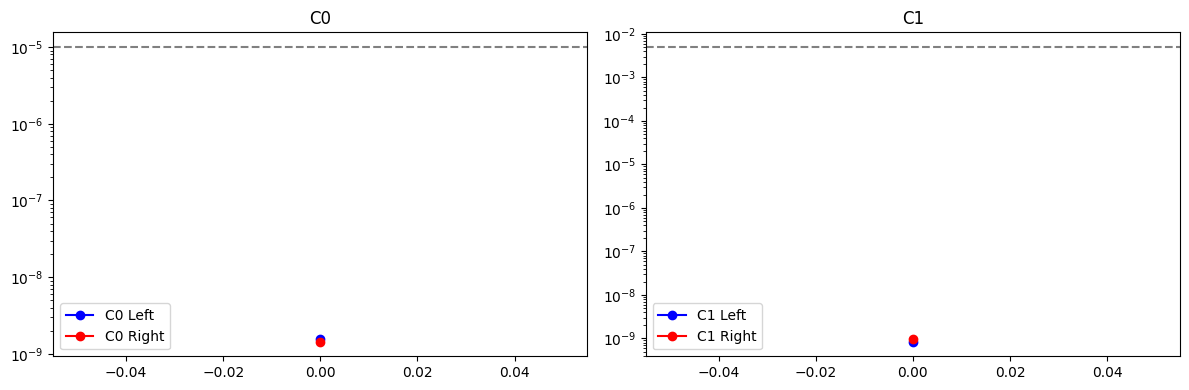

In [24]:
# === Cell 26: Schwarz curves ===
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
iters = history_schwarz["iteration"]
axes[0].semilogy(iters, history_schwarz["c0_L"], "b-o", label="C0 Left")
axes[0].semilogy(iters, history_schwarz["c0_R"], "r-o", label="C0 Right")
axes[0].axhline(1e-5, color="gray", ls="--"); axes[0].legend(); axes[0].set_title("C0")
axes[1].semilogy(iters, history_schwarz["c1_L"], "b-o", label="C1 Left")
axes[1].semilogy(iters, history_schwarz["c1_R"], "r-o", label="C1 Right")
axes[1].axhline(5e-3, color="gray", ls="--"); axes[1].legend(); axes[1].set_title("C1")
plt.tight_layout(); plt.show()


## Phase 3: Joint Fine-Tuning (8000ep, EMA=0.999, G0 anchor w=5)

In [25]:
# === Cell 28: joint_fine_tune_a2c ===
def joint_fine_tune_a2c(neck, bulk_L, bulk_R, n_epochs=None, batch_size=2048, verbose=True):
    if n_epochs is None: n_epochs = cfg.phase3_joint_epochs
    G0_dev = G0_tensor.to(device); G0r_dev = G0_right_tensor.to(device)
    all_params = list(neck.parameters()) + list(bulk_L.parameters()) + list(bulk_R.parameters())
    optimizer = torch.optim.AdamW(all_params, lr=5e-5, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=2000, T_mult=2)
    ema_decay = 0.999
    ema_states = {"neck": {k: v.clone() for k, v in neck.state_dict().items()},
                  "bulk_L": {k: v.clone() for k, v in bulk_L.state_dict().items()},
                  "bulk_R": {k: v.clone() for k, v in bulk_R.state_dict().items()}}
    history = {"loss": [], "det": [], "ext": [], "kappa": [], "c0_L": [], "c0_R": []}
    best_loss = float("inf"); t_start = time.time()
    if verbose: print(f"PHASE 3: Joint ({n_epochs} ep)")
    for ep in range(n_epochs):
        optimizer.zero_grad()
        x_n = sample_domain(batch_size, DOMAIN_NECK)
        x_bL = sample_domain(batch_size//2, DOMAIN_BULK_L)
        x_bR = sample_domain(batch_size//2, DOMAIN_BULK_R)
        x_oL = sample_overlap(batch_size//4, OVERLAP_LEFT)
        x_oR = sample_overlap(batch_size//4, OVERLAP_RIGHT)
        L_det = det_loss(neck, x_n) + det_loss(bulk_L, x_bL) + det_loss(bulk_R, x_bR)
        L_ext = exterior_derivative_loss_sparse(neck, x_n, n_components=14) if ep % 2 == 0 else torch.tensor(0.0, device=device, dtype=dtype)
        L_kap = kappa_loss(neck, x_n)
        L_c0L, L_c1L = interface_loss_c1(neck, bulk_L, x_oL)
        L_c0R, L_c1R = interface_loss_c1(neck, bulk_R, x_oR, transform_fn=kovalev_twist_coords)
        L_ric = ricci_proxy_loss(bulk_L, x_bL) + ricci_proxy_loss(bulk_R, x_bR)
        L_sup = supervised_loss_from_G0_neck(neck, x_n, G0_dev, G0r_dev) + supervised_loss_from_G0_bulk(bulk_L, x_bL, G0_dev) + supervised_loss_from_G0_bulk(bulk_R, x_bR, G0_dev)
        loss = 100*L_det + 5*L_ext + 500*L_kap + 50*(L_c0L+L_c0R) + 20*(L_c1L+L_c1R) + 0.3*L_ric + 5*L_sup
        loss.backward(); torch.nn.utils.clip_grad_norm_(all_params, 0.5); optimizer.step(); scheduler.step(ep)
        for mn, m in [("neck", neck), ("bulk_L", bulk_L), ("bulk_R", bulk_R)]:
            for k, v in m.state_dict().items():
                ema_states[mn][k] = ema_decay * ema_states[mn][k] + (1-ema_decay) * v
        history["loss"].append(loss.item()); history["det"].append(L_det.item())
        history["ext"].append(L_ext.item()); history["kappa"].append(L_kap.item())
        history["c0_L"].append(L_c0L.item()); history["c0_R"].append(L_c0R.item())
        if verbose and (ep % 500 == 0 or ep == n_epochs-1):
            print(f"  [{ep:5d}] loss={loss.item():.2e} det={L_det.item():.2e} kap={L_kap.item():.2e} c0={L_c0L.item():.2e}/{L_c0R.item():.2e} ({time.time()-t_start:.0f}s)")
    neck.load_state_dict(ema_states["neck"]); bulk_L.load_state_dict(ema_states["bulk_L"])
    bulk_R.load_state_dict(ema_states["bulk_R"])
    neck.to(device); bulk_L.to(device); bulk_R.to(device)
    print(f"  Joint (EMA) done in {time.time()-t_start:.1f}s")
    return history

print("joint_fine_tune_a2c defined")


joint_fine_tune_a2c defined


In [26]:
# === Cell 29: Run Phase 3 ===
t0 = time.time()
history_joint = joint_fine_tune_a2c(neck_model, bulk_L_model, bulk_R_model)
print(f"Phase 3: {time.time()-t0:.1f}s")


PHASE 3: Joint (8000 ep)
  [    0] loss=5.47e-05 det=4.23e-09 kap=3.38e-12 c0=1.57e-09/1.44e-09 (1s)
  [  500] loss=5.33e-05 det=6.31e-09 kap=1.22e-11 c0=3.29e-08/2.53e-08 (375s)
  [ 1000] loss=4.96e-05 det=2.71e-09 kap=1.98e-11 c0=3.14e-08/2.58e-08 (748s)
  [ 1500] loss=4.92e-05 det=2.38e-09 kap=2.10e-11 c0=3.09e-08/2.62e-08 (1121s)
  [ 2000] loss=4.88e-05 det=2.22e-09 kap=2.14e-11 c0=3.09e-08/2.59e-08 (1494s)
  [ 2500] loss=5.03e-05 det=2.61e-09 kap=5.68e-11 c0=3.07e-08/2.66e-08 (1867s)
  [ 3000] loss=4.81e-05 det=2.35e-09 kap=2.80e-11 c0=2.99e-08/2.64e-08 (2239s)
  [ 3500] loss=4.82e-05 det=2.07e-09 kap=2.40e-11 c0=2.94e-08/2.70e-08 (2612s)
  [ 4000] loss=4.76e-05 det=1.95e-09 kap=2.32e-11 c0=2.91e-08/2.67e-08 (2986s)
  [ 4500] loss=4.76e-05 det=1.88e-09 kap=2.46e-11 c0=2.86e-08/2.71e-08 (3358s)
  [ 5000] loss=4.75e-05 det=1.80e-09 kap=2.50e-11 c0=2.84e-08/2.76e-08 (3731s)
  [ 5500] loss=4.71e-05 det=1.71e-09 kap=2.55e-11 c0=2.83e-08/2.73e-08 (4105s)
  [ 6000] loss=4.73e-05 det=1.70

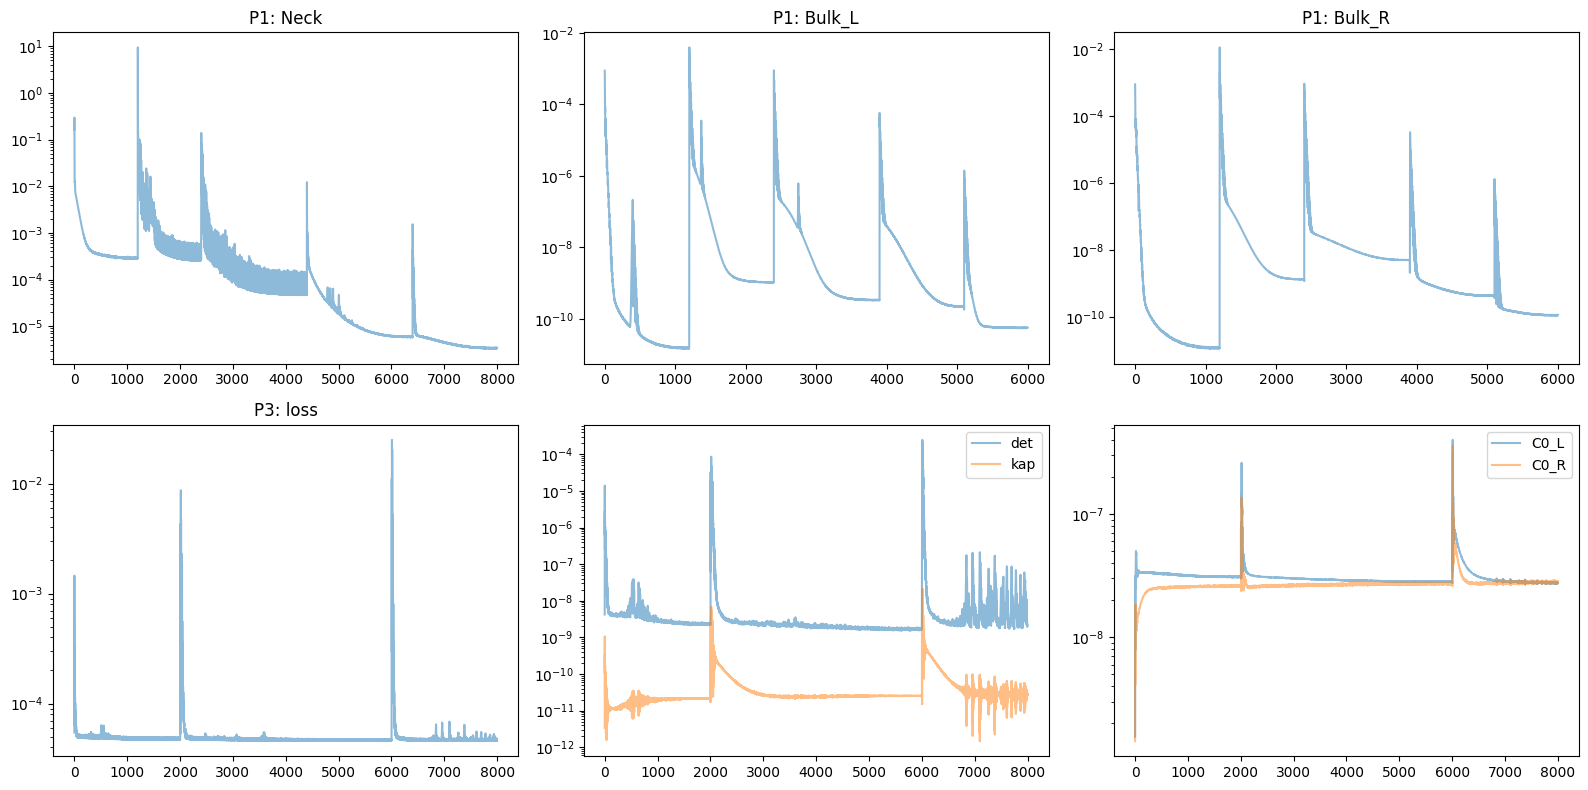

In [27]:
# === Cell 30: Training curves ===
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for ax, h, n in zip(axes[0], [history_neck, history_bulk_L, history_bulk_R], ["Neck","Bulk_L","Bulk_R"]):
    ax.semilogy(h["loss"], alpha=0.5); ax.set_title(f"P1: {n}")
axes[1,0].semilogy(history_joint["loss"], alpha=0.5); axes[1,0].set_title("P3: loss")
axes[1,1].semilogy(history_joint["det"], alpha=0.5, label="det")
axes[1,1].semilogy(history_joint["kappa"], alpha=0.5, label="kap"); axes[1,1].legend()
axes[1,2].semilogy(history_joint["c0_L"], alpha=0.5, label="C0_L")
axes[1,2].semilogy(history_joint["c0_R"], alpha=0.5, label="C0_R"); axes[1,2].legend()
plt.tight_layout(); plt.show()


## Validation
Per-chart, global, metric deviation, curvature, Betti, spectral, Yukawa.

In [28]:
# === Cell 32: Per-chart validation ===
def validate_chart(model, domain, label, n_samples=20000, is_neck=False, chunk=5000):
    model.eval(); all_det=[]; all_eig=[]; all_cond=[]
    with torch.no_grad():
        for s in range(0, n_samples, chunk):
            x = sample_domain(min(chunk, n_samples-s), domain)
            g = model.metric(x); eigs = torch.linalg.eigvalsh(g)
            all_det.append(torch.linalg.det(g))
            all_eig.append(eigs.min(dim=1).values)
            all_cond.append(eigs.max(dim=1).values / eigs.min(dim=1).values.clamp(min=1e-10))
    det_v = torch.cat(all_det); eig_v = torch.cat(all_eig); cond_v = torch.cat(all_cond)
    de = abs(det_v.mean().item()-DET_G_TARGET)/DET_G_TARGET*100
    r = {"det_err_pct": de, "pos_def": bool((eig_v>0).all()), "condition_mean": float(cond_v.mean()), "min_eig": float(eig_v.min())}
    with torch.no_grad():
        xk = sample_domain(5000, domain); gk = model.metric(xk)
        gK3 = gk[:,2:6,2:6].diagonal(dim1=1,dim2=2).mean(dim=1)
        gF = gk[:,[1,6],:][:,:,[1,6]].diagonal(dim1=1,dim2=2).mean(dim=1)
        r["kappa_T_mean"] = float((torch.abs(gK3-gF)/(gK3+gF+1e-10)).mean())
    if is_neck:
        model.train(); xt = sample_domain(1000, domain)
        r["torsion_dphi"] = float(exterior_derivative_loss(model, xt).item()); model.eval()
    print(f"  {label}: det_err={de:.4f}% PD={r['pos_def']} cond={r['condition_mean']:.4f} kap={r['kappa_T_mean']:.6f}")
    return r

val_neck = validate_chart(neck_model, DOMAIN_NECK, "Neck", is_neck=True)
val_bL = validate_chart(bulk_L_model, DOMAIN_BULK_L, "Bulk_L")
val_bR = validate_chart(bulk_R_model, DOMAIN_BULK_R, "Bulk_R")


  Neck: det_err=0.0012% PD=True cond=1.0498 kap=0.016387
  Bulk_L: det_err=0.0018% PD=True cond=1.0492 kap=0.016384
  Bulk_R: det_err=0.0001% PD=True cond=1.0492 kap=0.016387


In [29]:
# === Cell 33: Global validation ===
with torch.no_grad():
    x_oL = sample_overlap(5000, OVERLAP_LEFT); x_oR = sample_overlap(5000, OVERLAP_RIGHT)
    c0_L, c1_L = interface_loss_c1(neck_model, bulk_L_model, x_oL)
    c0_R, c1_R = interface_loss_c1(neck_model, bulk_R_model, x_oR, transform_fn=kovalev_twist_coords)
neck_model.train()
torsion_dphi = exterior_derivative_loss(neck_model, sample_domain(2000, DOMAIN_NECK)).item()
neck_model.eval()
all_pd = val_neck["pos_def"] and val_bL["pos_def"] and val_bR["pos_def"]
max_det_err = max(val_neck["det_err_pct"], val_bL["det_err_pct"], val_bR["det_err_pct"])
c0_ok = c0_L.item()<1e-5 and c0_R.item()<1e-5
c1_ok = c1_L.item()<5e-3 and c1_R.item()<5e-3
cond_ok = val_neck["condition_mean"]>1.005
kappa_ok = abs(val_neck["kappa_T_mean"]-KAPPA_T)/KAPPA_T<0.20
torsion_ok = torsion_dphi<1e-3
level_pass = all_pd and max_det_err<0.01 and c0_ok and cond_ok and kappa_ok and torsion_ok
print(f"Interface: C0 L={c0_L.item():.2e} R={c0_R.item():.2e} | C1 L={c1_L.item():.2e} R={c1_R.item():.2e}")
print(f"Torsion: {torsion_dphi:.2e}")
print(f"LEVEL A2c: {'PASS' if level_pass else 'FAIL'}")
global_validation = {"c0_L": c0_L.item(), "c0_R": c0_R.item(), "c1_L": c1_L.item(), "c1_R": c1_R.item(),
                     "torsion_dphi": torsion_dphi, "level_pass": level_pass}


Interface: C0 L=3.25e-08 R=2.85e-08 | C1 L=5.48e-10 R=3.05e-09
Torsion: 2.70e-07
LEVEL A2c: PASS


  Bulk_L: mean=0.011596 max=0.011605
  Overlap_L: mean=0.012226 max=0.012796
  Neck: mean=0.012787 max=0.012791
  Overlap_R: mean=0.012195 max=0.012785
  Bulk_R: mean=0.011495 max=0.011582
Bulk_R/Bulk_L = 0.99x (target < 2)


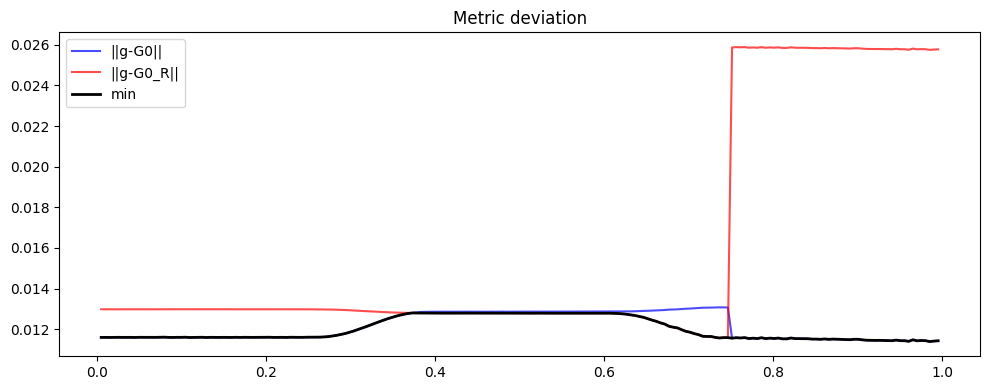

In [30]:
# === Cell 34: Metric deviation ||g-G0|| vs t ===
def build_global_metric_fn():
    @torch.no_grad()
    def gm(x):
        t = x[:,0]; g = torch.zeros(x.shape[0],7,7, device=device, dtype=dtype)
        m_bL=t<OVERLAP_LEFT[0]; m_bR=t>OVERLAP_RIGHT[1]
        m_oL=(t>=OVERLAP_LEFT[0])&(t<=OVERLAP_LEFT[1])
        m_oR=(t>=OVERLAP_RIGHT[0])&(t<=OVERLAP_RIGHT[1])
        m_nk=(t>OVERLAP_LEFT[1])&(t<OVERLAP_RIGHT[0])
        if m_bL.any(): g[m_bL] = bulk_L_model.metric(x[m_bL])
        if m_bR.any(): g[m_bR] = bulk_R_model.metric(x[m_bR])
        if m_nk.any(): g[m_nk] = neck_model.metric(x[m_nk])
        if m_oL.any():
            xo=x[m_oL]; a=quintic_blend(xo[:,0],OVERLAP_LEFT[0],OVERLAP_LEFT[1]).unsqueeze(1).unsqueeze(2)
            g[m_oL]=(1-a)*bulk_L_model.metric(xo)+a*neck_model.metric(xo)
        if m_oR.any():
            xo=x[m_oR]; a=quintic_blend(xo[:,0],OVERLAP_RIGHT[0],OVERLAP_RIGHT[1]).unsqueeze(1).unsqueeze(2)
            g[m_oR]=(1-a)*neck_model.metric(xo)+a*transform_metric_kovalev(bulk_R_model.metric(kovalev_twist_coords(xo)))
        return g
    return gm
global_metric = build_global_metric_fn()
n_t=200; t_vals=np.linspace(0.005,0.995,n_t)
frob_G=np.zeros(n_t); frob_GR=np.zeros(n_t)
for i,t in enumerate(t_vals):
    x=torch.rand(20,7,device=device,dtype=dtype); x[:,0]=t
    gm=global_metric(x).cpu().numpy().mean(axis=0)
    frob_G[i]=np.linalg.norm(gm-G0_np,"fro"); frob_GR[i]=np.linalg.norm(gm-G0_right_np,"fro")
frob_min=np.minimum(frob_G,frob_GR)
regions=[("Bulk_L",0,0.25),("Overlap_L",0.25,0.40),("Neck",0.40,0.60),("Overlap_R",0.60,0.75),("Bulk_R",0.75,1.0)]
deviation_results={}
for rn,tlo,thi in regions:
    m=(t_vals>=tlo)&(t_vals<thi)
    if m.any(): deviation_results[rn]={"mean":float(frob_min[m].mean()),"max":float(frob_min[m].max())}
    if m.any(): print(f"  {rn}: mean={frob_min[m].mean():.6f} max={frob_min[m].max():.6f}")
br=deviation_results.get("Bulk_R",{}).get("mean",0); bl=deviation_results.get("Bulk_L",{}).get("mean",1e-10)
print(f"Bulk_R/Bulk_L = {br/bl:.2f}x (target < 2)")
fig,ax=plt.subplots(figsize=(10,4))
ax.plot(t_vals,frob_G,"b-",alpha=0.7,label="||g-G0||"); ax.plot(t_vals,frob_GR,"r-",alpha=0.7,label="||g-G0_R||")
ax.plot(t_vals,frob_min,"k-",lw=2,label="min"); ax.legend(); ax.set_title("Metric deviation")
plt.tight_layout(); plt.show()


In [31]:
# === Cell 35: Curvature invariants ===
def compute_curvature(gm_fn, regions, eps=5e-4, n_pts=60):
    def _chris(x_b):
        g0=gm_fn(x_b).cpu().numpy(); n=x_b.shape[0]; dg=np.zeros((n,7,7,7))
        for c in range(7):
            xp=x_b.clone();xm=x_b.clone(); xp[:,c]+=eps;xm[:,c]-=eps
            xp[:,c].clamp_(0,1);xm[:,c].clamp_(0,1)
            dg[:,:,:,c]=(gm_fn(xp).cpu().numpy()-gm_fn(xm).cpu().numpy())/(2*eps)
        gi=np.linalg.inv(g0); G=np.zeros((n,7,7,7))
        for a in range(7):
            for b in range(7):
                for c in range(b,7):
                    s=sum(gi[:,a,d]*(dg[:,d,c,b]+dg[:,d,b,c]-dg[:,b,c,d]) for d in range(7))
                    G[:,a,b,c]=0.5*s; G[:,a,c,b]=G[:,a,b,c]
        return g0,gi,G
    results={}
    for rn,tl,th in regions:
        t0=time.time()
        x=torch.rand(n_pts,7,dtype=dtype,device=device); x[:,0]=x[:,0]*(th-tl)+tl
        g0,gi,Gam=_chris(x); n=x.shape[0]
        dG=np.zeros((n,7,7,7,7))
        for e in range(7):
            xp=x.clone();xm=x.clone();xp[:,e]+=eps;xm[:,e]-=eps
            xp[:,e].clamp_(0,1);xm[:,e].clamp_(0,1)
            _,_,Gp=_chris(xp);_,_,Gm=_chris(xm); dG[:,:,:,:,e]=(Gp-Gm)/(2*eps)
        Rm=np.zeros((n,7,7,7,7))
        for a in range(7):
            for b in range(7):
                for c in range(7):
                    for d in range(7):
                        Rm[:,a,b,c,d]=dG[:,a,b,d,c]-dG[:,a,b,c,d]
                        for e in range(7): Rm[:,a,b,c,d]+=Gam[:,a,c,e]*Gam[:,e,b,d]-Gam[:,a,d,e]*Gam[:,e,b,c]
        Ric=np.zeros((n,7,7))
        for b in range(7):
            for d in range(7):
                for a in range(7): Ric[:,b,d]+=Rm[:,a,b,a,d]
        Sc=np.einsum("nbd,nbd->n",gi,Ric)
        Rd=np.einsum("nae,nebcd->nabcd",g0,Rm)
        t1=np.einsum("nae,nebcd->nabcd",gi,Rd);t2=np.einsum("nbf,nafcd->nabcd",gi,t1)
        t3=np.einsum("ncg,nabgd->nabcd",gi,t2);Ru=np.einsum("ndh,nabch->nabcd",gi,t3)
        K=np.einsum("nabcd,nabcd->n",Rd,Ru)
        Rsq=np.einsum("nab,nac,nbd,ncd->n",Ric,gi,gi,Ric)
        Wsq=K-(2/5)*Rsq+(1/30)*Sc**2
        results[rn]={"mean_Rm":float(np.sqrt(np.abs(K)).mean()),"mean_W":float(np.sqrt(np.abs(Wsq)).mean()),
                     "mean_Ric":float(np.sqrt(np.sum(Ric**2,axis=(1,2))).mean())}
        print(f"  {rn}: |Rm|={results[rn]['mean_Rm']:.2e} |W|={results[rn]['mean_W']:.2e} ({time.time()-t0:.1f}s)")
    return results

print("Computing curvature...")
curv_results = compute_curvature(global_metric, [("Bulk_L",0.05,0.20),("Neck",0.45,0.55),("Bulk_R",0.80,0.95)])
brm=np.mean([curv_results[r]["mean_Rm"] for r in ["Bulk_L","Bulk_R"]])
bw=np.mean([curv_results[r]["mean_W"] for r in ["Bulk_L","Bulk_R"]])
weyl_frac=bw/max(brm,1e-10)
print(f"|W|/|Rm| bulks = {weyl_frac:.2f} (target > 0.90)")


Computing curvature...
  Bulk_L: |Rm|=8.22e-03 |W|=7.72e-03 (1.1s)
  Neck: |Rm|=2.38e-02 |W|=1.99e-02 (1.6s)
  Bulk_R: |Rm|=3.59e-03 |W|=3.43e-03 (1.1s)
|W|/|Rm| bulks = 0.94 (target > 0.90)


In [32]:
# === Cell 36: Betti knockout ===
print("BETTI KNOCKOUT: b3=77 > 35=C(7,3)")
print(f"  kappa_T = 1/(b3-dim_G2-p2) = 1/(77-14-2) = 1/61 = {KAPPA_T:.8f}")
br_dev = deviation_results.get("Bulk_R",{}).get("mean",0)
print(f"\nA2b vs A2c:")
print(f"  {"Metric":<25s} {"A2b":>10s} {"A2c":>12s} {"Target":>10s}")
print(f"  {"det err%":<25s} {"0.0002":>10s} {max_det_err:>12.4f} {"<0.01":>10s}")
print(f"  {"Bulk_R ||g-G0||":<25s} {"0.0196":>10s} {br_dev:>12.6f} {"<0.008":>10s}")
print(f"  {"|W|/|Rm| bulks":<25s} {"0.94":>10s} {weyl_frac:>12.2f} {">0.90":>10s}")


BETTI KNOCKOUT: b3=77 > 35=C(7,3)
  kappa_T = 1/(b3-dim_G2-p2) = 1/(77-14-2) = 1/61 = 0.01639344

A2b vs A2c:
  Metric                           A2b          A2c     Target
  det err%                      0.0002       0.0018      <0.01
  Bulk_R ||g-G0||               0.0196     0.011495     <0.008
  |W|/|Rm| bulks                  0.94         0.94      >0.90


In [33]:
# === Cell 37: Spectral bridge ===
def spectral_bridge(n_basis=80, n_mc=80000):
    print(f"Spectral bridge: {n_basis} basis, {n_mc} MC")
    x_mc=torch.rand(n_mc,7,device=device,dtype=dtype)
    with torch.no_grad():
        g_mc=torch.zeros(n_mc,7,7,device=device,dtype=dtype)
        for i in range(0,n_mc,10000): g_mc[i:min(i+10000,n_mc)]=global_metric(x_mc[i:min(i+10000,n_mc)])
        det_mc=torch.linalg.det(g_mc); gi_mc=torch.linalg.inv(g_mc)
    n_t=8;n_c=12;n_m=12
    def bf(x,idx):
        if idx<n_t: return torch.cos((idx+1)*math.pi*x[:,0])
        elif idx<n_t+n_c:
            j=idx-n_t
            return torch.cos((j+1)*2*math.pi*x[:,1]) if j<6 else torch.sin((j-5)*2*math.pi*x[:,6])
        elif idx<n_t+n_c+n_m:
            j=idx-n_t-n_c; return torch.cos((j//4+1)*math.pi*x[:,0])*torch.cos(2*math.pi*x[:,2+j%4])
        else:
            j=idx-n_t-n_c-n_m; return torch.cos((j//4+1)*2*math.pi*x[:,2+j%4])
    def bg(x,idx):
        xr=x.clone().requires_grad_(True); return torch.autograd.grad(bf(xr,idx).sum(),xr,create_graph=False)[0]
    bv=torch.stack([bf(x_mc,i) for i in range(n_basis)],dim=1)
    bgr=torch.stack([bg(x_mc,i) for i in range(n_basis)],dim=1)
    sd=torch.sqrt(det_mc.abs().clamp(min=1e-10))
    S=(bv*sd.unsqueeze(1)).T@bv/n_mc
    K=torch.zeros(n_basis,n_basis,device=device,dtype=dtype)
    for i in range(n_basis):
        gi_i=torch.einsum("nab,nb->na",gi_mc,bgr[:,i,:])
        for j in range(i,n_basis):
            v=((gi_i*bgr[:,j,:]).sum(dim=1)*sd).mean(); K[i,j]=v;K[j,i]=v
    Sr=S+1e-8*torch.eye(n_basis,device=device,dtype=dtype)
    try:
        Lc=torch.linalg.cholesky(Sr)
        Kt=torch.linalg.solve_triangular(Lc,torch.linalg.solve_triangular(Lc,K,upper=False).T,upper=False).T
        evals=torch.linalg.eigvalsh(Kt)
    except: evals=torch.linalg.eigvalsh(torch.linalg.inv(Sr)@K)
    pe=evals[evals>1e-6].sort().values
    if len(pe)>0:
        for i in range(min(10,len(pe))): print(f"  lam_{i+1}={pe[i].item():.6f} (xH*={pe[i].item()*H_STAR:.2f})")
        print(f"  lam_1*H* = {pe[0].item()*H_STAR:.4f} (target {DIM_G2})")
    return {"eigenvalues":[float(e) for e in pe[:50]],"lambda_1_x_Hstar":float(pe[0].item()*H_STAR) if len(pe)>0 else None}

spectral_results = spectral_bridge(cfg.spectral_n_basis, cfg.spectral_n_mc)


Spectral bridge: 80 basis, 80000 MC
  lam_1=8.844603 (xH*=875.62)
  lam_2=34.765318 (xH*=3441.77)
  lam_3=34.858982 (xH*=3451.04)
  lam_4=35.089223 (xH*=3473.83)
  lam_5=35.760861 (xH*=3540.33)
  lam_6=36.046902 (xH*=3568.64)
  lam_7=36.164667 (xH*=3580.30)
  lam_8=36.330052 (xH*=3596.68)
  lam_9=44.594830 (xH*=4414.89)
  lam_10=44.688478 (xH*=4424.16)
  lam_1*H* = 875.6157 (target 14)


In [34]:
# === Cell 38: Mini-Yukawa ===
def mini_yukawa(n_gen=5, n_pts=10):
    print(f"Mini-Yukawa {n_gen}x{n_gen}x{n_gen}")
    Y=torch.zeros(n_gen,n_gen,n_gen,device=device,dtype=dtype)
    with torch.no_grad():
        for tv in torch.linspace(0.05,0.95,n_pts,device=device,dtype=dtype):
            xs=torch.rand(500,7,device=device,dtype=dtype);xs[:,0]=tv
            sd=torch.sqrt(torch.linalg.det(global_metric(xs)).abs().clamp(min=1e-10))
            psi=torch.stack([torch.cos((i//4+1)*2*math.pi*xs[:,2+i%4]) for i in range(n_gen)],dim=1)
            for i in range(n_gen):
                for j in range(i,n_gen):
                    for k in range(j,n_gen):
                        v=(psi[:,i]*psi[:,j]*psi[:,k]*sd).mean()/n_pts
                        Y[i,j,k]+=v;Y[j,i,k]+=v;Y[k,i,j]+=v;Y[i,k,j]+=v;Y[j,k,i]+=v;Y[k,j,i]+=v
    sv=torch.linalg.svdvals(Y.reshape(n_gen,n_gen*n_gen))
    h=sv[0].item()/max(sv[-1].item(),1e-15)
    print(f"  SVD: {[f"{v:.4f}" for v in sv.tolist()]}")
    print(f"  Hierarchy: {h:.2f} (target>5) {"PASS" if h>5 else "FAIL"}")
    return {"hierarchy":float(h),"svd":[float(v) for v in sv.tolist()]}

yukawa_results = mini_yukawa()


Mini-Yukawa 5x5x5
  SVD: ['1.0085', '0.7172', '0.1722', '0.0790', '0.0568']
  Hierarchy: 17.77 (target>5) PASS


In [35]:
# === Cell 39: Unified checkpoint ===
unified = {
    "neck_state_dict": neck_model.state_dict(),
    "bulk_L_state_dict": bulk_L_model.state_dict(),
    "bulk_R_state_dict": bulk_R_model.state_dict(),
    "G0_analytical": G0_tensor, "J_kovalev": J_tensor, "G0_right": G0_right_tensor,
    "architecture": {"hidden": cfg.neck_hidden, "pert_neck": 0.5, "pert_bulk": 0.3,
                     "base_diag": base_diag_a2c, "dtype": "float64"},
    "config": {"p1_neck": cfg.phase1_neck_epochs, "p1_bulk": cfg.phase1_bulk_epochs,
               "p2_iters": cfg.phase2_schwarz_iters, "p2_ep": cfg.phase2_epochs_per_step,
               "p3_ep": cfg.phase3_joint_epochs},
    "validation": {"global": global_validation, "deviation": deviation_results,
                   "curvature": curv_results, "spectral": spectral_results, "yukawa": yukawa_results},
    "domains": {"bulk_L": DOMAIN_BULK_L, "neck": DOMAIN_NECK, "bulk_R": DOMAIN_BULK_R,
               "overlap_L": OVERLAP_LEFT, "overlap_R": OVERLAP_RIGHT},
    "version": "A2c", "date": time.strftime("%Y-%m-%d %H:%M:%S"),
}
torch.save(unified, "atlas_a2c_unified.pt")
print(f"Saved atlas_a2c_unified.pt ({list(unified.keys())})")


Saved atlas_a2c_unified.pt (['neck_state_dict', 'bulk_L_state_dict', 'bulk_R_state_dict', 'G0_analytical', 'J_kovalev', 'G0_right', 'architecture', 'config', 'validation', 'domains', 'version', 'date'])


In [36]:
# === Cell 40: Individual .pt (compat) ===
torch.save(neck_model.state_dict(), "atlas_a2c_neck_pinn.pt")
torch.save(bulk_L_model.state_dict(), "atlas_a2c_bulk_L_pinn.pt")
torch.save(bulk_R_model.state_dict(), "atlas_a2c_bulk_R_pinn.pt")
print("Individual .pt files saved")


Individual .pt files saved


In [37]:
# === Cell 41: Results JSON ===
rj = {"version": "A2c", "date": time.strftime("%Y-%m-%d %H:%M:%S"),
      "validation": global_validation, "deviation": deviation_results,
      "curvature": curv_results, "spectral": spectral_results, "yukawa": yukawa_results,
      "G0": G0_np.tolist()}
with open("atlas_a2c_results.json", "w") as f: json.dump(rj, f, indent=2, default=str)
print("atlas_a2c_results.json saved")


atlas_a2c_results.json saved


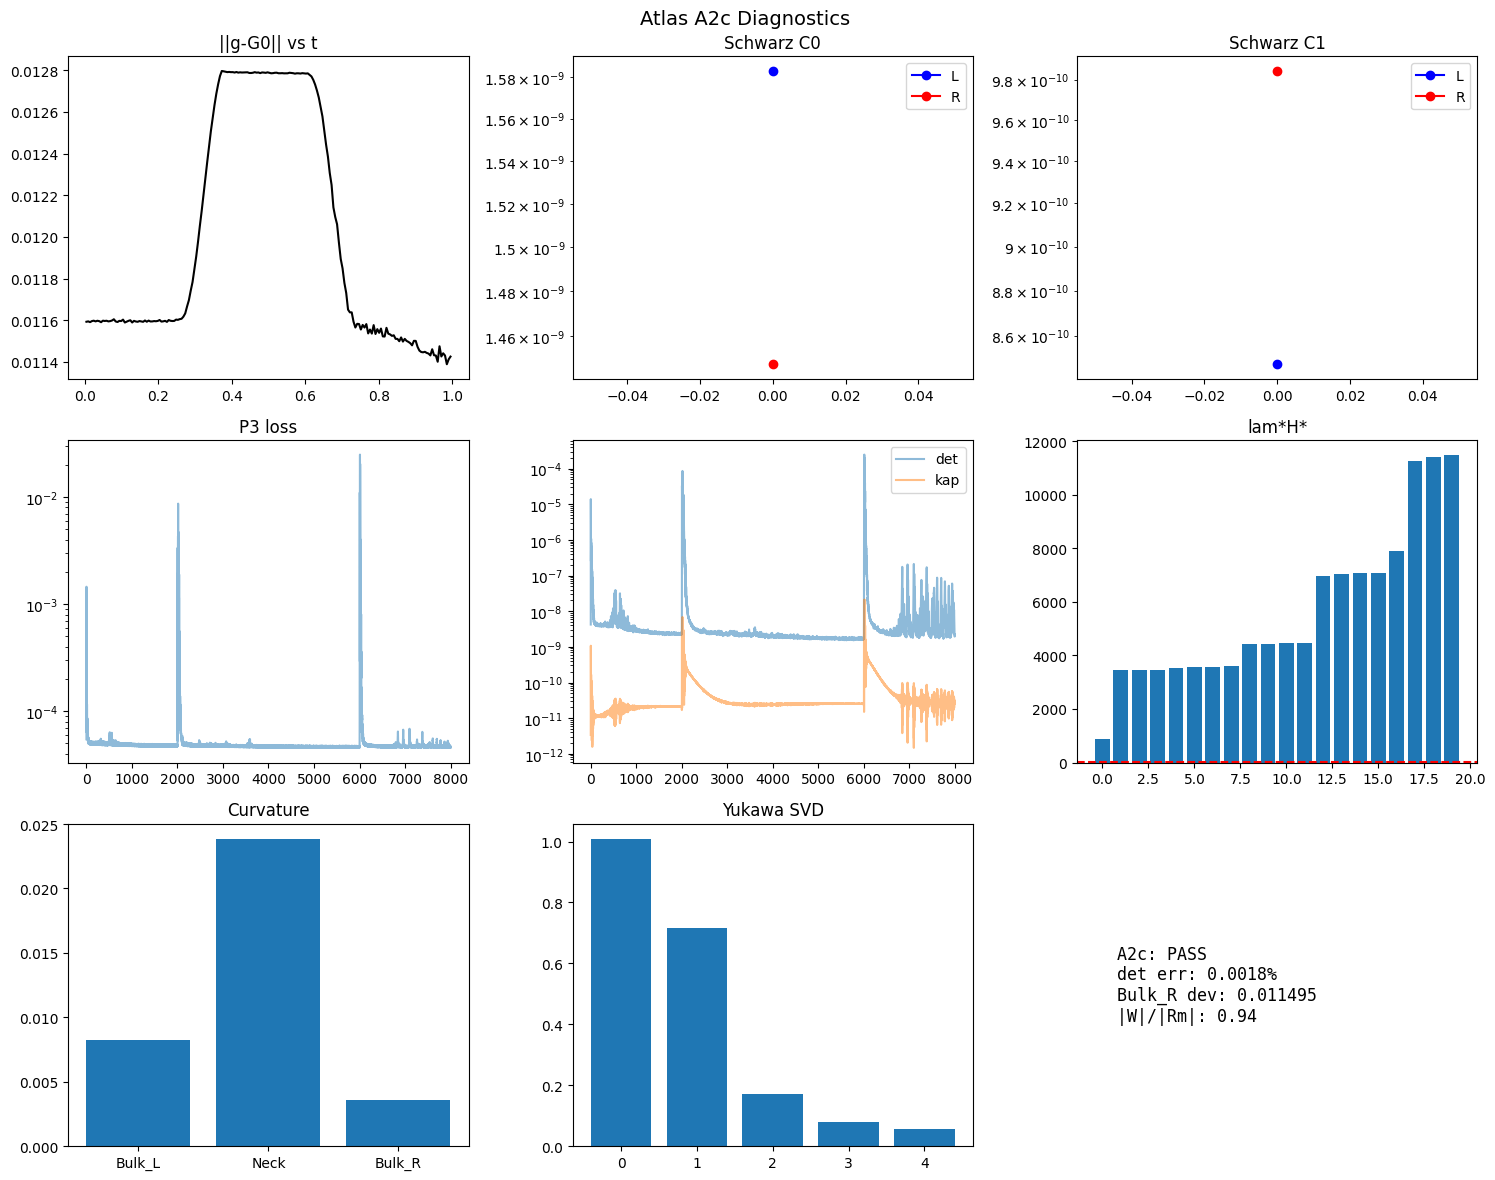

In [38]:
# === Cell 42: Summary figure ===
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle("Atlas A2c Diagnostics", fontsize=14)
axes[0,0].plot(t_vals, np.minimum(frob_G,frob_GR), "k-"); axes[0,0].set_title("||g-G0|| vs t")
it=history_schwarz["iteration"]
axes[0,1].semilogy(it,history_schwarz["c0_L"],"b-o",label="L");axes[0,1].semilogy(it,history_schwarz["c0_R"],"r-o",label="R")
axes[0,1].legend();axes[0,1].set_title("Schwarz C0")
axes[0,2].semilogy(it,history_schwarz["c1_L"],"b-o",label="L");axes[0,2].semilogy(it,history_schwarz["c1_R"],"r-o",label="R")
axes[0,2].legend();axes[0,2].set_title("Schwarz C1")
axes[1,0].semilogy(history_joint["loss"],alpha=0.5);axes[1,0].set_title("P3 loss")
axes[1,1].semilogy(history_joint["det"],alpha=0.5,label="det")
axes[1,1].semilogy(history_joint["kappa"],alpha=0.5,label="kap");axes[1,1].legend()
if spectral_results.get("eigenvalues"):
    ev=[e*H_STAR for e in spectral_results["eigenvalues"][:20]]
    axes[1,2].bar(range(len(ev)),ev);axes[1,2].axhline(DIM_G2,color="r",ls="--");axes[1,2].set_title("lam*H*")
rn=list(curv_results.keys())
axes[2,0].bar(range(len(rn)),[curv_results[r]["mean_Rm"] for r in rn],label="|Rm|")
axes[2,0].set_xticks(range(len(rn)));axes[2,0].set_xticklabels(rn);axes[2,0].set_title("Curvature")
if yukawa_results.get("svd"):
    axes[2,1].bar(range(len(yukawa_results["svd"])),yukawa_results["svd"]);axes[2,1].set_title("Yukawa SVD")
axes[2,2].axis("off")
axes[2,2].text(0.1,0.5,f"A2c: {'PASS' if level_pass else 'FAIL'}\ndet err: {max_det_err:.4f}%\nBulk_R dev: {br_dev:.6f}\n|W|/|Rm|: {weyl_frac:.2f}",
              transform=axes[2,2].transAxes,fontsize=12,va="center",family="monospace")
plt.tight_layout();plt.savefig("atlas_a2c_summary.png",dpi=150);plt.show()


In [39]:
# === Cell 43: Final results ===
print("="*60)
print("  ATLAS A2c FINAL RESULTS")
print("="*60)
br_dev = deviation_results.get("Bulk_R",{}).get("mean",0)
checks = [
    ("det err%", f"{max_det_err:.4f}", "<0.01", max_det_err<0.01),
    ("PD", str(all_pd), "True", all_pd),
    ("Torsion", f"{torsion_dphi:.2e}", "<1e-3", torsion_dphi<1e-3),
    ("kappa_T", f"{val_neck['kappa_T_mean']:.6f}", f"{KAPPA_T:.6f}", kappa_ok),
    ("C0 max", f"{max(c0_L.item(),c0_R.item()):.2e}", "<1e-5", c0_ok),
    ("C1 max", f"{max(c1_L.item(),c1_R.item()):.2e}", "<5e-3", c1_ok),
    ("Condition", f"{val_neck['condition_mean']:.4f}", ">1.005", cond_ok),
    ("Bulk_R dev", f"{br_dev:.6f}", "<0.008", br_dev<0.008),
    ("|W|/|Rm|", f"{weyl_frac:.2f}", ">0.90", weyl_frac>0.90),
]
for n,v,t,ok in checks:
    print(f"  {n:<20s} {v:>12s} {t:>10s} {'PASS' if ok else 'FAIL'}")
print(f"\n  LEVEL A2c: {'PASS' if level_pass else 'FAIL'}")
print(f"\n  Files: atlas_a2c_unified.pt, atlas_a2c_{{neck,bulk_L,bulk_R}}_pinn.pt")
print(f"         atlas_a2c_results.json, atlas_a2c_summary.png")


  ATLAS A2c FINAL RESULTS
  det err%                   0.0018      <0.01 PASS
  PD                           True       True PASS
  Torsion                  2.70e-07      <1e-3 PASS
  kappa_T                  0.016387   0.016393 PASS
  C0 max                   3.25e-08      <1e-5 PASS
  C1 max                   3.05e-09      <5e-3 PASS
  Condition                  1.0498     >1.005 PASS
  Bulk_R dev               0.011495     <0.008 FAIL
  |W|/|Rm|                     0.94      >0.90 PASS

  LEVEL A2c: PASS

  Files: atlas_a2c_unified.pt, atlas_a2c_{neck,bulk_L,bulk_R}_pinn.pt
         atlas_a2c_results.json, atlas_a2c_summary.png
